In [16]:
# Data wrangling
import numpy as np
import os
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
%load_ext rpy2.ipython

# Statistics
import math
from tslearn.barycenters import euclidean_barycenter, dtw_barycenter_averaging

# Set seed for reproducibility
seed=0
import random
random.seed(seed)
np.random.seed(seed)


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [17]:
%%R 

# Load packages needed for visualization in R
suppressPackageStartupMessages({
    library(colorspace)
    library(cowplot)
    library(glue)
    library(patchwork)
    library(tidyverse)
    library(viridis)
    #Set cowplot theme
    theme_set(theme_cowplot())
    
})



## Define network and input objects and the Euler-Maruyama solver

In [18]:
# network and input objects

class network_model:
    def __init__(self, num_nodes, weights, tau_X, tau_H, arousal,g,sigma):
        self.num_nodes = num_nodes
        self.W = weights
        self.tau_X = tau_X
        self.tau_H = tau_H
        self.arousal = arousal
        self.g = g
        self.sigma = sigma

class network_input:
    def __init__(self, num_nodes, stim_onset, burnin, stim_offset, sim_length, lesion):
        I_ext = np.zeros((num_nodes, sim_length))
        I_ext[0, stim_onset + burnin:stim_offset + burnin] = 1
        self.I_ext = I_ext
        self.lesion = lesion 

# define solver

def euler_maruyama(nw,input,DT,T,sim_length, seed=0):
    # Set seed for reproducibility
    np.random.seed(seed)
    
    # Initial conditions / storage structures
    X = np.zeros((nw.num_nodes, sim_length))
    H = np.zeros((nw.num_nodes, sim_length))

    # numerical integration
    for tt in range(sim_length - 1):
        
        DX = (-X[:, tt] + np.maximum(nw.W @ X[:, tt] + input.I_ext[:, tt] - nw.g * H[:, tt] + input.lesion + nw.arousal, 0)) / nw.tau_X
        DH = (-H[:, tt] + X[:, tt]) / nw.tau_H
        DW_X = nw.sigma * np.sqrt(DT) * np.random.randn(nw.num_nodes)
        DW_H = nw.sigma * np.sqrt(DT) * np.random.randn(nw.num_nodes)

        X[:, tt + 1] = X[:, tt] + DT * DX + DW_X
        H[:, tt + 1] = H[:, tt] + DT * DH + DW_H

    return X, H


#### simulation params

DT = 1   
T = 3000
sim_length = len(np.arange(0, T + DT, DT)) - 1

#### shared model params

tau_H = 400
sigma = 0.005
arousal = 0.85

#### IIT model params
n_nodes_IIT = 2
tau_X_IIT = np.array([20, 30])
W_VIS_VIS = 0.1
W_cs_VIS = 0.75
W_VIS_cs = 0.75
W_cs_cs = 0.1


g_IIT = 0.5 # weak adaptation

W_IIT = np.array([[W_VIS_VIS, W_VIS_cs],
              [W_cs_VIS, W_cs_cs]])

IIT_net = network_model(n_nodes_IIT,W_IIT,tau_X_IIT,tau_H,arousal,g_IIT,sigma)

#### GNWT model params
n_nodes_GNWT = 3
tau_X_GNWT = np.array([30, 50, 50])

# CS
W_cs1_cs1 = 0.05
W_pfc1_cs1 = .75
W_pfc2_cs1 = .75
# PFC1
W_cs1_pfc1 = 0.25
W_pfc1_pfc1 = 0.25
W_pfc2_pfc1 = -2.5
# PFC2
W_cs1_pfc2 = 0.25
W_pfc1_pfc2 = -2.5
W_pfc2_pfc2 = .25

W_GNWT = np.array([[W_cs1_cs1, W_cs1_pfc1, W_cs1_pfc2],
              [W_pfc1_cs1, W_pfc1_pfc1, W_pfc1_pfc2],
              [W_pfc2_cs1,  W_pfc2_pfc1,  W_pfc2_pfc2]])

g_GNWT = 1; # strong adaptation

GNWT_net = network_model(n_nodes_GNWT,W_GNWT,tau_X_GNWT,tau_H,arousal,g_GNWT,sigma)

#### shared input params
burnin = int(500 / DT)
stim_onset = int(500 / DT)
stim_offset = int(1500 / DT)

#### IIT input params
VIS_lesion = 0
cs_lesion = 0
lesion_IIT = np.array([VIS_lesion, cs_lesion])

IIT_input = network_input(n_nodes_IIT, stim_onset, burnin, stim_offset, sim_length, lesion_IIT)

#### GNWT input params
cs_lesion = 0
pfc1_lesion = 0
pfc2_lesion = 0
lesion_GNWT = np.array([cs_lesion, pfc1_lesion, pfc2_lesion])

GNWT_input = network_input(n_nodes_GNWT, stim_onset, burnin, stim_offset, sim_length, lesion_GNWT)


## Run the simulations and perform preprocessing (baseline subtraction)

In [19]:
# run simulations if not already saved
N_sims = 1000
data_path = "simulated_data/"

if os.path.isfile(f'{data_path}/X_IIT_{N_sims}_sims.npy'):
    X_IIT = np.load(f'{data_path}/X_IIT_{N_sims}_sims.npy')
    H_IIT = np.load(f'{data_path}/H_IIT_{N_sims}_sims.npy')
    X_GNWT = np.load(f'{data_path}/X_GNWT_{N_sims}_sims.npy')
    H_GNWT = np.load(f'{data_path}/H_GNWT_{N_sims}_sims.npy')

else:
    # Initialize storage arrays
    X_IIT = np.zeros((n_nodes_IIT, sim_length,N_sims))
    H_IIT = np.zeros((n_nodes_IIT, sim_length,N_sims))
    X_GNWT = np.zeros((n_nodes_GNWT, sim_length,N_sims))
    H_GNWT = np.zeros((n_nodes_GNWT, sim_length,N_sims))

    for n in range(N_sims):
        if n % 50 == 0:
            print(n)
        [X_IIT[:,:,n],H_IIT[:,:,n]] = euler_maruyama(IIT_net,IIT_input,DT,T,sim_length, seed=n)
        [X_GNWT[:,:,n],H_GNWT[:,:,n]] = euler_maruyama(GNWT_net,GNWT_input,DT,T,sim_length, seed=n)

    # Save simulations
    np.save(f'{data_path}/X_IIT_{N_sims}_sims.npy', X_IIT)
    np.save(f'{data_path}/H_IIT_{N_sims}_sims.npy', H_IIT)
    np.save(f'{data_path}/X_GNWT_{N_sims}_sims.npy', X_GNWT)
    np.save(f'{data_path}/H_GNWT_{N_sims}_sims.npy', H_GNWT)


# Preprocessing: remove burn-in and perform baseline subtraction
VIS = X_IIT[0,burnin:] - np.mean(X_IIT[0,burnin:stim_onset+burnin])
CS_IIT = X_IIT[1,burnin:] - np.mean(X_IIT[0,burnin:stim_onset+burnin])

PFC = np.squeeze(np.mean(X_GNWT[1:,burnin:],axis=0) - np.mean(np.mean(X_GNWT[1:,burnin:stim_onset+burnin], axis=1, keepdims=True)))
CS_GNWT = X_GNWT[0,burnin:] - np.mean(X_GNWT[0,burnin:stim_onset+burnin])

## Neural activity figures:

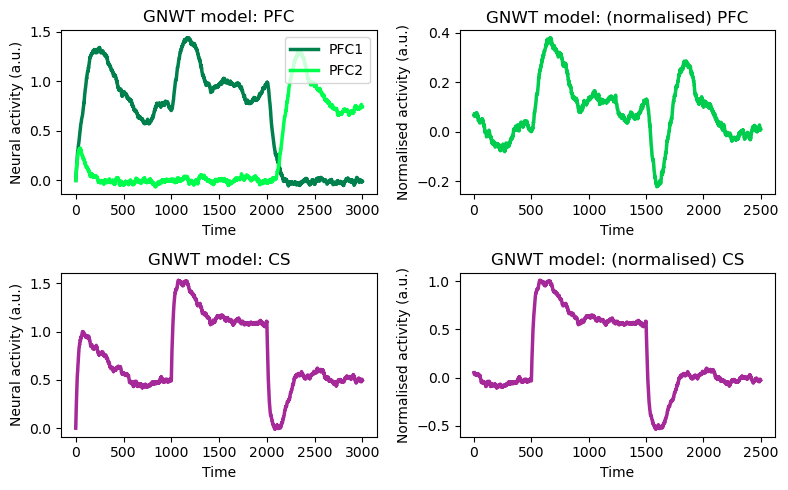

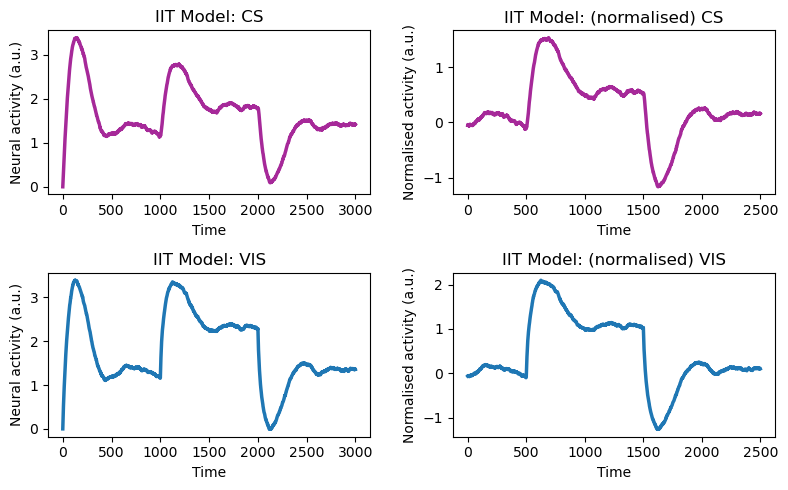

In [20]:
# figures 
example_trl = 5
fig, axs = plt.subplots(2, 2, figsize=(8, 5))

# Subplot 1: Activity
axs[0, 0].plot(X_GNWT[1,:,example_trl].T, color = [0, .5, .3],linewidth=2.5)
axs[0, 0].plot(X_GNWT[2,:,example_trl].T, color = [0, 1, .3],linewidth=2.5)
axs[0, 0].set_title('GNWT model: PFC')
axs[0, 0].legend(['PFC1', 'PFC2'],loc='upper right')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Neural activity (a.u.)')

# Subplot 2: normalised activity
axs[0, 1].plot(PFC[:,example_trl], color = [0, .8, .3],linewidth=2.5)
axs[0, 1].set_title('GNWT model: (normalised) PFC')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Normalised activity (a.u.)')

# Subplot 3: Stim on
axs[1, 0].plot(X_GNWT[0,:,example_trl].T, color = [.65, .16, .6],linewidth=2.5)
axs[1, 0].set_title('GNWT model: CS')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Neural activity (a.u.)')

# Subplot 4: Stim off
axs[1, 1].plot(CS_GNWT[:,example_trl], color = [.65, .16, .6],linewidth=2.5)
axs[1, 1].set_title('GNWT model: (normalised) CS')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Normalised activity (a.u.)')

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(8, 5))

# Subplot 1: Activity
axs[0, 0].plot(X_IIT[1,:,example_trl].T, color = [.65, .16, .6],linewidth=2.5)
axs[0, 0].set_title('IIT Model: CS')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Neural activity (a.u.)')

# Subplot 2: normalised activity
axs[0, 1].plot(CS_IIT[:,example_trl], color = [.65, .16, .6],linewidth=2.5)
axs[0, 1].set_title('IIT Model: (normalised) CS')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Normalised activity (a.u.)')

# Subplot 3: Stim on
axs[1, 0].plot(X_IIT[0,:,example_trl].T,linewidth=2.5)
axs[1, 0].set_title('IIT Model: VIS')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Neural activity (a.u.)')

# Subplot 4: Stim off
axs[1, 1].plot(VIS[:,example_trl],linewidth=2.5)
axs[1, 1].set_title('IIT Model: (normalised) VIS')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Normalised activity (a.u.)')


plt.tight_layout()
plt.show()


In [25]:
if not os.path.isfile(f'All_simulated_Euclidean_barycenter_squared_max_results_{N_sims}_sims.csv'):
    # grab the stim on and off time series and add measurment noise
    max_barycenter_res_across_noise_values_list = []

    # Iterate over each measurement noise value
    for measurement_noise in [0.5, 0.6, 0.7, 0.8, 0.9, 1]:
        if not os.path.isfile(f'{data_path}/GNWT_stim_on_{N_sims}_sims_noise_{measurement_noise}.npy'):
            # Set seed for reproducibility
            random.seed(seed)
            np.random.seed(seed)

            #### IIT model
            VIS_stim_on = VIS[stim_onset:stim_offset] + np.random.randn(len(VIS[stim_onset:stim_offset]),N_sims)*measurement_noise
            CS_IIT_stim_on = CS_IIT[stim_onset:stim_offset] + np.random.randn(len(CS_IIT[stim_onset:stim_offset]),N_sims)*measurement_noise
            VIS_stim_off = VIS[stim_offset:] + np.random.randn(len(VIS[stim_offset:]),N_sims)*measurement_noise
            CS_IIT_stim_off = CS_IIT[stim_offset:] + np.random.randn(len(CS_IIT[stim_offset:]),N_sims)*measurement_noise

            # Combine into 2D array 
            time_series_IIT_stim_on = np.array([CS_IIT_stim_on, VIS_stim_on])
            time_series_IIT_stim_off = np.array([CS_IIT_stim_off, VIS_stim_off])

            #### GNWT model
            PFC_stim_on = PFC[stim_onset:stim_offset] + np.random.randn(len(PFC[stim_onset:stim_offset]),N_sims)*measurement_noise
            CS_GNWT_stim_on = CS_GNWT[stim_onset:stim_offset] + np.random.randn(len(CS_GNWT[stim_onset:stim_offset]),N_sims)*measurement_noise
            PFC_stim_off = PFC[stim_offset:] + np.random.randn(len(PFC[stim_offset:]),N_sims)*measurement_noise
            CS_GNWT_stim_off = CS_GNWT[stim_offset:] + np.random.randn(len(CS_GNWT[stim_offset:]),N_sims)*measurement_noise

            # Combine into a 2D array 
            time_series_GNWT_stim_on = np.array([CS_GNWT_stim_on, PFC_stim_on])
            time_series_GNWT_stim_off = np.array([CS_GNWT_stim_off, PFC_stim_off])

            # Save to .npy files
            np.save(f'{data_path}/GNWT_stim_on_{N_sims}_sims_noise_{measurement_noise}.npy', time_series_GNWT_stim_on)
            np.save(f'{data_path}/GNWT_stim_off_{N_sims}_sims_noise_{measurement_noise}.npy', time_series_GNWT_stim_off)
            np.save(f'{data_path}/IIT_stim_on_{N_sims}_sims_noise_{measurement_noise}.npy', time_series_IIT_stim_on)
            np.save(f'{data_path}/IIT_stim_off_{N_sims}_sims_noise_{measurement_noise}.npy', time_series_IIT_stim_off)

        else:
            time_series_GNWT_stim_on = np.load(f'{data_path}/GNWT_stim_on_{N_sims}_sims_noise_{measurement_noise}.npy')
            time_series_GNWT_stim_off = np.load(f'{data_path}/GNWT_stim_off_{N_sims}_sims_noise_{measurement_noise}.npy')
            time_series_IIT_stim_on = np.load(f'{data_path}/IIT_stim_on_{N_sims}_sims_noise_{measurement_noise}.npy')
            time_series_IIT_stim_off = np.load(f'{data_path}/IIT_stim_off_{N_sims}_sims_noise_{measurement_noise}.npy')


        # Compute the Euclidean barycenter
        barycenter_IIT_stim_on = euclidean_barycenter(time_series_IIT_stim_on)**2
        barycenter_IIT_stim_off = euclidean_barycenter(time_series_IIT_stim_off)**2
        barycenter_GNWT_stim_on = euclidean_barycenter(time_series_GNWT_stim_on)**2
        barycenter_GNWT_stim_off = euclidean_barycenter(time_series_GNWT_stim_off)**2

        # Also compute for absolute values
        barycenter_IIT_stim_on_abs = euclidean_barycenter(np.abs(time_series_IIT_stim_on))**2
        barycenter_IIT_stim_off_abs = euclidean_barycenter(np.abs(time_series_IIT_stim_off))**2
        barycenter_GNWT_stim_on_abs = euclidean_barycenter(np.abs(time_series_GNWT_stim_on))**2
        barycenter_GNWT_stim_off_abs = euclidean_barycenter(np.abs(time_series_GNWT_stim_off))**2

        # Compute the timepoint of max barycenter
        max_barycenter_IIT_stim_on = np.argmax(barycenter_IIT_stim_on, axis=0)
        max_barycenter_IIT_stim_off = np.argmax(barycenter_IIT_stim_off, axis=0)
        max_barycenter_GNWT_stim_on = np.argmax(barycenter_GNWT_stim_on, axis=0)
        max_barycenter_GNWT_stim_off = np.argmax(barycenter_GNWT_stim_off, axis=0)

        max_barycenter_IIT_stim_on_abs = np.argmax(barycenter_IIT_stim_on_abs, axis=0)
        max_barycenter_IIT_stim_off_abs = np.argmax(barycenter_IIT_stim_off_abs, axis=0)
        max_barycenter_GNWT_stim_on_abs = np.argmax(barycenter_GNWT_stim_on_abs, axis=0)
        max_barycenter_GNWT_stim_off_abs = np.argmax(barycenter_GNWT_stim_off_abs, axis=0)

        # Compute the value of the max barycenter
        max_barycenter_val_IIT_stim_on = np.max(barycenter_IIT_stim_on, axis=0)
        max_barycenter_val_IIT_stim_off = np.max(barycenter_IIT_stim_off, axis=0)
        max_barycenter_val_GNWT_stim_on = np.max(barycenter_GNWT_stim_on, axis=0)
        max_barycenter_val_GNWT_stim_off = np.max(barycenter_GNWT_stim_off, axis=0)

        max_barycenter_val_IIT_stim_on_abs = np.max(barycenter_IIT_stim_on_abs, axis=0)
        max_barycenter_val_IIT_stim_off_abs = np.max(barycenter_IIT_stim_off_abs, axis=0)
        max_barycenter_val_GNWT_stim_on_abs = np.max(barycenter_GNWT_stim_on_abs, axis=0)
        max_barycenter_val_GNWT_stim_off_abs = np.max(barycenter_GNWT_stim_off_abs, axis=0)

        # Combine max timing + value into a dataframe
        max_barycenter_this_noise_df = pd.DataFrame({
            'Max_Time': np.concatenate((max_barycenter_IIT_stim_on, max_barycenter_IIT_stim_off, max_barycenter_GNWT_stim_on, max_barycenter_GNWT_stim_off)),
            'Model': np.concatenate((np.repeat('IIT', N_sims*2), np.repeat('GNWT', N_sims*2))),
            'Stim': np.concatenate((np.repeat('On', N_sims), np.repeat('Off', N_sims), np.repeat('On', N_sims), np.repeat('Off', N_sims))),
            'Max_Value': np.concatenate((max_barycenter_val_IIT_stim_on, max_barycenter_val_IIT_stim_off, max_barycenter_val_GNWT_stim_on, max_barycenter_val_GNWT_stim_off)),
            'Data_Type': np.repeat('Raw', N_sims*4),
            'Noise': np.repeat(measurement_noise, N_sims*4)
        })

        # Combine max timing + value into a dataframe for absolute value
        max_barycenter_this_noise_df_abs = pd.DataFrame({
            'Max_Time': np.concatenate((max_barycenter_IIT_stim_on_abs, max_barycenter_IIT_stim_off_abs, max_barycenter_GNWT_stim_on_abs, max_barycenter_GNWT_stim_off_abs)),
            'Model': np.concatenate((np.repeat('IIT', N_sims*2), np.repeat('GNWT', N_sims*2))),
            'Stim': np.concatenate((np.repeat('On', N_sims), np.repeat('Off', N_sims), np.repeat('On', N_sims), np.repeat('Off', N_sims))),
            'Max_Value': np.concatenate((max_barycenter_val_IIT_stim_on_abs, max_barycenter_val_IIT_stim_off_abs, max_barycenter_val_GNWT_stim_on_abs, max_barycenter_val_GNWT_stim_off_abs)),
            'Data_Type': np.repeat('Abs', N_sims*4),
            'Noise': np.repeat(measurement_noise, N_sims*4)
        })

        # Append to list
        max_barycenter_res_across_noise_values_list.append(max_barycenter_this_noise_df)
        max_barycenter_res_across_noise_values_list.append(max_barycenter_this_noise_df_abs)

    # Combine into a single dataframe
    max_barycenter_res_across_noise_values = pd.concat(max_barycenter_res_across_noise_values_list)

    # Save to csv
    max_barycenter_res_across_noise_values.to_csv(f'All_simulated_Euclidean_barycenter_squared_max_results_{N_sims}_sims.csv', index=False)

else:
    # Load from csv
    max_barycenter_res_across_noise_values = pd.read_csv(f'All_simulated_Euclidean_barycenter_squared_max_results_{N_sims}_sims.csv')

# Separate out into raw and abs
max_barycenter_res_across_noise_values_raw = max_barycenter_res_across_noise_values[max_barycenter_res_across_noise_values['Data_Type'] == 'Raw']
max_barycenter_res_across_noise_values_abs = max_barycenter_res_across_noise_values[max_barycenter_res_across_noise_values['Data_Type'] == 'Abs']

## Plot the distribution of maximum barycenters

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


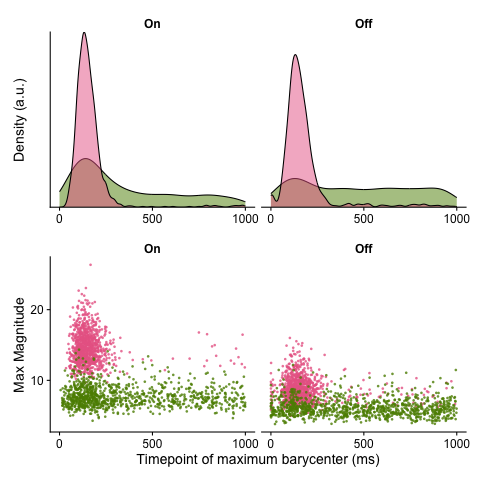

In [24]:
%%R -i max_barycenter_res_across_noise_values_raw

bary_max_density_plot <- max_barycenter_res_across_noise_values_raw %>% 
    filter(Noise==1) %>%
    mutate(Stim = factor(Stim, levels=c("On", "Off"))) %>%
    ggplot(data=., mapping=aes(x=Max_Time, fill=Model)) +
    scale_fill_manual(values=c("IIT" = "#e96893", "GNWT" = "#5b8c00"))  +
    scale_x_continuous(expand=c(0,0)) +
    scale_y_continuous(expand=c(0,0)) +
    geom_density(alpha=0.5) +
    facet_grid(. ~ Stim, scales="free") +
    ylab("Density (a.u.)") +
    xlab("Timepoint of maximum barycenter (ms)") +
    theme(axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          legend.position="none",
          strip.background = element_blank(),
            strip.text.x = element_text(face='bold'),
            strip.text.y = element_text(angle=0, face='bold'))

bary_max_scatter_plot <- max_barycenter_res_across_noise_values_raw %>% 
    filter(Noise==1) %>%
    mutate(Stim = factor(Stim, levels=c("On", "Off"))) %>%
    ggplot(data=., mapping=aes(x=Max_Time, y=Max_Value, color=Model)) +
    geom_point(stroke=0, alpha=0.8, size=1.25) +
    facet_grid(. ~ Stim, scales="free")  +
    scale_color_manual(values=c("IIT" = "#e96893", "GNWT" = "#5b8c00"))  +
    ylab("Max Magnitude") +
    xlab("Timepoint of maximum barycenter (ms)")  +
    theme(legend.position="none",
          strip.background = element_blank(),
            strip.text.x = element_text(face='bold'),
            strip.text.y = element_text(angle=0, face='bold'))

wrap_plots(list(bary_max_density_plot, bary_max_scatter_plot), ncol=1) +
      plot_layout(axis_titles = "collect", guides = "collect") &
      scale_x_continuous(breaks=c(0, 500, 1000), limits=c(0, 1000))